In [10]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [11]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [12]:
len(words)

32033

In [13]:
# building the vocabulary of charcters and mappings to integers and integer to characters
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [14]:
block_size = 3 # context length from how man y words we predict the next one

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

xtr,  ytr  = build_dataset(words[:n1])     # 80%
xdev, ydev = build_dataset(words[n1:n2])   # 10%
xte,  yte  = build_dataset(words[n2:])     #10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:

n_embd = 10 # the dimensionality of the character look up we can multiply it with block size
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)*(5/3)/((n_embd * block_size)**0.5) #scaling factor for tanh is 5/3 and here divide with sqrt of fanin
b1 = torch.randn(n_hidden,                        generator=g)*0.01 
W2 = torch.randn((n_hidden, vocab_size),          generator=g)*0.01 
b2 = torch.randn(vocab_size,                      generator=g)*0  # multiply with 0 to reduce the logits value closer to 0

parameters = [C, W1, W2, b2,]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True #it keep tracks the gradient

11697


In [128]:
hpreact.mean(0,keepdim=True)

tensor([[-0.8651, -0.3529, -0.7097,  0.3659,  0.7088,  0.8335,  2.6702, -0.7828,
         -1.2194,  1.5310, -1.3748, -2.1678, -0.2089, -0.3678,  0.2171,  1.2024,
          0.9170, -1.3031, -0.7402,  1.2836,  0.7912, -1.1587,  0.7721,  0.9071,
          1.0507,  0.7063,  0.2378,  0.3377, -0.2322,  1.1440, -0.6078, -0.1327,
         -0.4078,  1.3006, -1.3817, -2.0271, -0.2379, -1.0624, -1.0890,  0.0128,
         -0.1068, -1.7052, -0.9121, -0.7137,  0.2546, -0.4217,  0.1466, -0.5415,
          2.5326,  2.7152,  0.7075,  0.2301,  2.3030,  1.5006,  1.9624, -1.0813,
         -0.3374,  1.3636,  1.9027, -0.3903, -0.1022,  0.4231, -0.0561, -0.2593,
          0.8938,  0.9277,  1.1884, -0.0836, -0.7741,  0.9738, -1.4517,  1.8728,
          0.8597, -1.9799, -2.8256,  0.0433,  0.7107,  0.1288, -0.4350, -0.2341,
          0.8904,  2.0423,  0.8340,  0.7421, -0.2390,  0.4309, -1.8387, -0.3401,
          0.8720, -0.5243,  0.1026,  1.3360, -0.9290, -0.4603, -1.2951, -0.8643,
         -2.1152, -0.5701,  

In [127]:
hpreact.shape

torch.Size([32, 200])

In [ ]:
# using xtr and ytr
max_steps=200000
batch_size=32 #using  minibatch
lossi=[]
for i in range(max_steps):
    ix=torch.randint(0,xtr.shape[0],(batch_size,),generator = g) #mini batch constructed
    xb,yb=xtr[ix],ytr[ix]
    emb=C[xb] #32,3,10
    embcat=emb.view(emb.shape[0],-1) #in -1 pytorch automatically assigns the value
    hpreact=embcat @ W1 + b1 #hidden layer pre activation
    h=torch.tanh( hpreact)
    logits=h @ W2 + b2
    loss=F.cross_entropy(logits,yb)# loss function

    #backward pass
    for p in parameters:
         p.grad=None
    loss.backward()
    #update
    lr=0.01
    for p in parameters:
         p.data+=-lr*p.grad
    if i%10000==0:
         print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())
    


      0/ 200000:3.3179
  10000/ 200000:2.2284
  20000/ 200000:2.3442
  30000/ 200000:2.5755
  40000/ 200000:1.9519
  50000/ 200000:2.4751
  60000/ 200000:2.4350
  70000/ 200000:2.1092
  80000/ 200000:2.2407
  90000/ 200000:2.1468
 100000/ 200000:2.0061
 110000/ 200000:2.1845
 120000/ 200000:1.9676
 130000/ 200000:2.3589
 140000/ 200000:2.2752
 150000/ 200000:2.2309
 160000/ 200000:1.8293
 170000/ 200000:1.7493
 180000/ 200000:1.9836
 190000/ 200000:1.8667


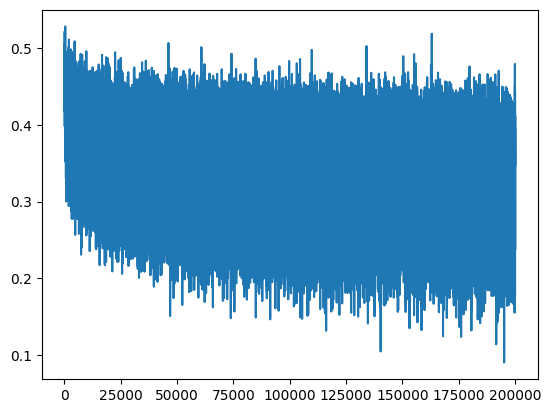

In [60]:
plt.plot(lossi)

In [ ]:
logits[0]

tensor([ -2.3527,  36.4366, -10.7306,   5.7165,  18.6409, -11.6998,  -2.1991,
          1.8535,  10.9996,  10.6730,  12.3507, -10.3809,   4.7243, -24.4257,
         -8.5909,   1.9024, -12.2744, -12.4751, -23.2778,  -2.0163,  25.8767,
         14.2108,  17.7691, -10.9204, -20.7335,   6.4560,  11.1615],
       grad_fn=<SelectBackward0>)

In [ ]:
#when we use relu it destroys half in the negative site , to compensate this with a gain we use sd=sqrt(2/N_in)
#in gaussian distribution ,the mean is 0 and unit variance,0 or 1 sd
#in batch normalization reduce the loss by adjustingh the mean and variance across a mini batch

In [ ]:
@torch.no_grad() #this disables gradient tracking
def split_loss(split):
    x,y={
    'train' : (xtr,ytr),
    'val' : (xdev,ydev),
    'test': (xte,yte),
    }[split] # it takes the train and val string in the list
    emb=C[x] #(N,blocksize,n_embd)
    embcat=emb.view(emb.shape[0],-1) #concat with (N,blocksize* n_embd)
    hpreact=embcat @ W1 + b1 #N,n_hidden 
    h=torch.tanh( hpreact)
    logits=h @ W2 + b2
    loss=F.cross_entropy(logits,y)# loss function
    print(split,loss.item())
split_loss('train')
split_loss('val')

train 2.100076198577881
val 2.1391818523406982


In [77]:
# loss 
#  fix softmax confidently---->
# train 2.1446988582611084
# val 2.1785755157470703
# fix tanh layer at init------>
# train 2.0994210243225098
# val 2.1359660625457764



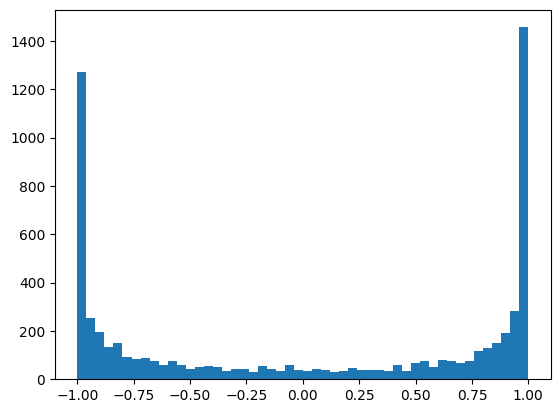

In [87]:
plt.hist(h.view(-1).tolist(),50); #tanh doesn't affect the loss because it is a flat surface(refer tanh backward in micrograd)

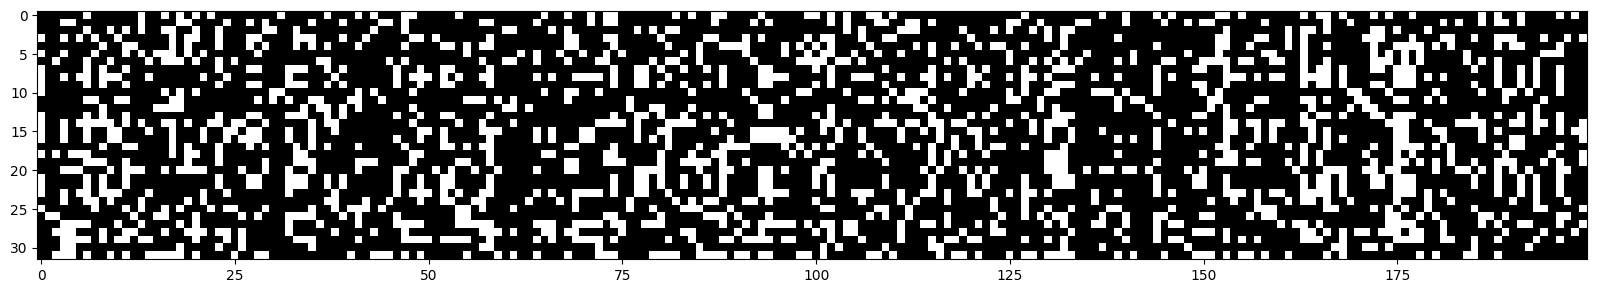

In [122]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99,cmap='grey',interpolation='nearest')
#in 200 colums if one row is fully white (i.e) true is dead neuron and does not learn anything

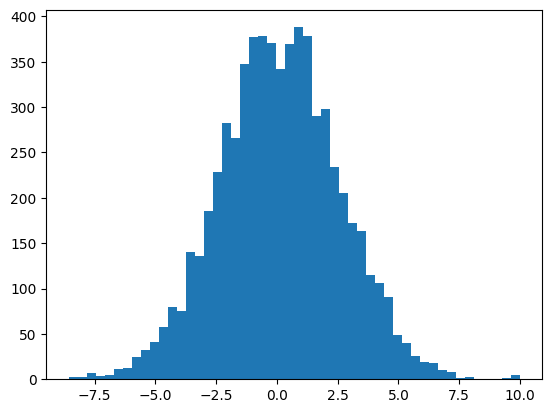

In [123]:
plt.hist(hpreact.view(-1).tolist(),50);

In [121]:
(torch.rand(1000)*0.2).std()

tensor(0.0563)

tensor(0.0116) tensor(0.9905)
tensor(0.0173) tensor(0.5761)


(array([4.60937327e-05, 9.21874654e-05, 4.60937327e-05, 9.21874654e-05,
        2.76562396e-04, 5.53124792e-04, 5.53124792e-04, 1.61328064e-03,
        1.88984304e-03, 3.27265502e-03, 6.49921631e-03, 8.71171548e-03,
        1.57179628e-02, 2.56742091e-02, 3.95484226e-02, 6.30562263e-02,
        9.15421531e-02, 1.28417139e-01, 1.75156184e-01, 2.36460849e-01,
        3.03711605e-01, 3.88339698e-01, 4.68911543e-01, 5.53170886e-01,
        6.31898981e-01, 6.93203646e-01, 7.17541137e-01, 7.05372391e-01,
        6.77670058e-01, 6.26598202e-01, 5.58056822e-01, 4.83892006e-01,
        3.90229541e-01, 3.25836596e-01, 2.48076469e-01, 1.92717896e-01,
        1.45287445e-01, 1.01821056e-01, 6.99702862e-02, 4.61398264e-02,
        3.26804565e-02, 2.24015541e-02, 1.50726506e-02, 8.98827787e-03,
        4.97812313e-03, 3.54921742e-03, 1.79765557e-03, 1.10624958e-03,
        2.30468663e-04, 2.76562396e-04]),
 array([-2.92634654e+00, -2.81787192e+00, -2.70939731e+00, -2.60092269e+00,
        -2.4924480

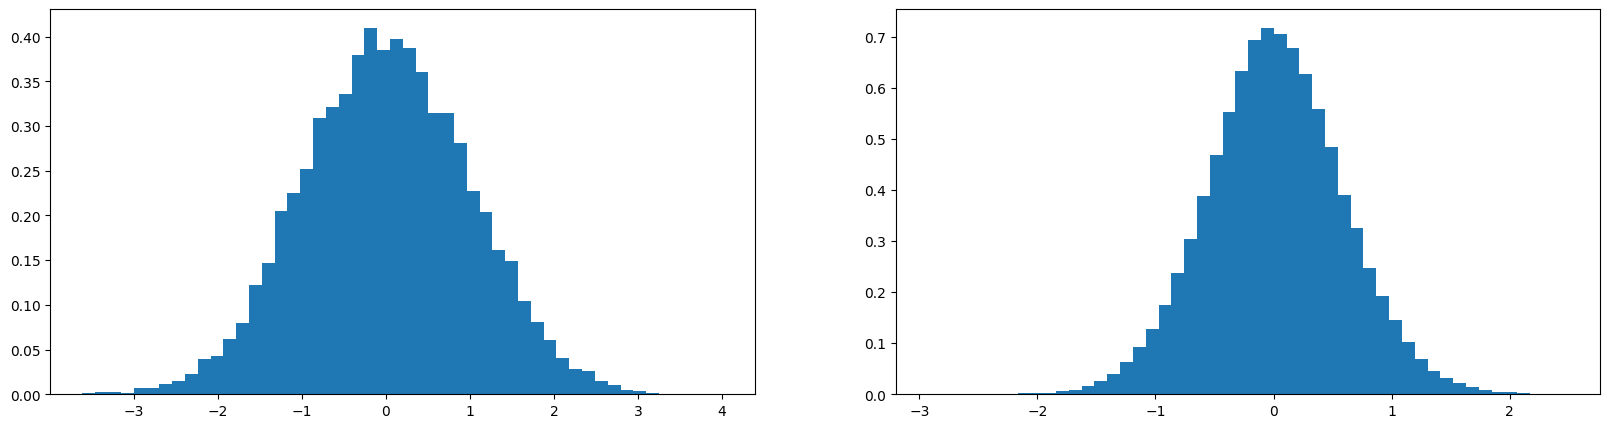

In [124]:
x=torch.randn(1000,10)
w=torch.rand(10,200) /10**0.5
y=x@w
print(x.mean(),x.std())
print(y.mean(),y.std())
plt.figure(figsize=[20,5])
plt.subplot(121)
plt.hist(x.view(-1).tolist(),50,density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(),50,density=True)
